In [33]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.decomposition.asf import ASF
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.optimization.saver import load_checkpoint
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.utils.configs import inertial_config_two_link_workspace, get_mesh_builder, inertial_config_two_link_six_trajectories

In [34]:
import tkinter as tk
from tkinter import filedialog

def select_directory():
    # Create a root window
    root = tk.Tk()
    # Hide the root window
    root.withdraw()
    # Make the root window the topmost window
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Open directory dialog and store the selected directory path
    directory_path = filedialog.askdirectory(initialdir="./",
        title="Select a directory"
    )
    root.update_idletasks() 
    root.destroy()
    # Check if a directory was selected
    if directory_path:
        #print(f"Selected directory: {directory_path}")
        return directory_path
    else:
        #print("No directory selected")
        return None

# Call the function to open the directory dialog
selected_directory = select_directory()
print(f"Resulting directory path: {selected_directory}")

Resulting directory path: D:/work/projects/mechanism_builder/apps/experiments/all_topologies_acc_hl_six_trajectories/results/first_setup/all_topologies_100gen_64pop/topology_8_2024-11-01_22-18-06


In [35]:
problem = MultiCriteriaProblem.load(
    selected_directory
)
 
checkpoint = load_checkpoint(selected_directory)
optimizer = PymooOptimizer(problem, checkpoint)
optimizer.load_history(selected_directory)
res = optimizer.run()

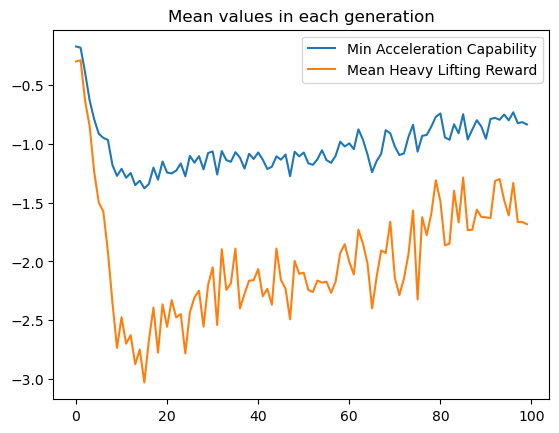

In [36]:
history_mean = optimizer.history["Mean"]
plt.plot(np.arange(len(history_mean)), history_mean)
labels = []
for trajectory_idx, rewards in problem.rewards_and_trajectories.rewards.items():
    for reward in rewards:
        labels.append(reward[0].reward_name)
plt.legend(labels)
plt.title("Mean values in each generation")
plt.show()


points on front: 64
Scale f1: [-1.8344049576918282, -1.1139434117575486]
Scale f2: [-5.985449381843012, -1.8960818041958198]


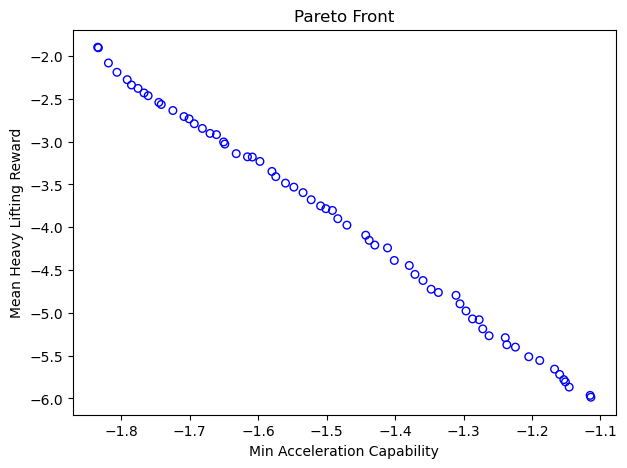

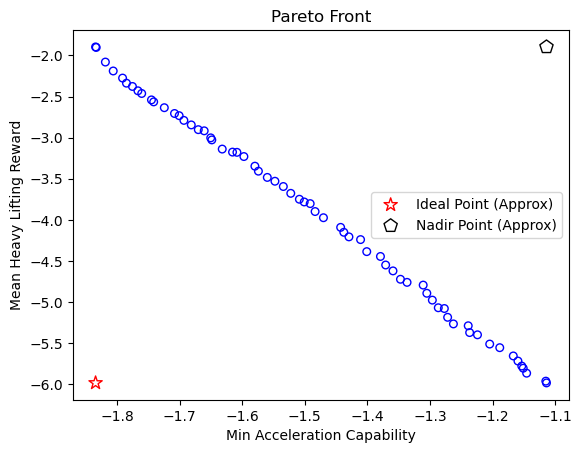

In [37]:
F = res.F
print('points on front:',len(F))
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title('Pareto Front')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.show()
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none',
            edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none',
            edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title('Pareto Front')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.legend()
plt.show()

Text(0.5, 1.0, 'Total history and final front')

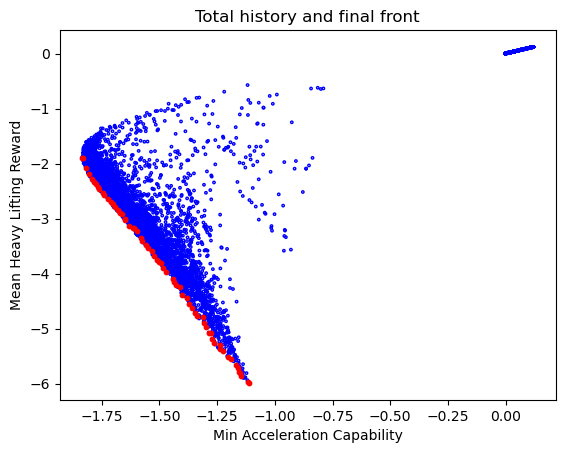

In [38]:
optimizer.history["F"]
plt.scatter(np.array(optimizer.history["F"])[:,0], np.array(optimizer.history["F"])[:,1],s=3,facecolors='none', edgecolors='blue')
plt.scatter(res.F[:,0], res.F[:,1],color='red',s=10)
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title('Total history and final front')

Best regarding ASF: F = [-1.27188712 -5.18687341]


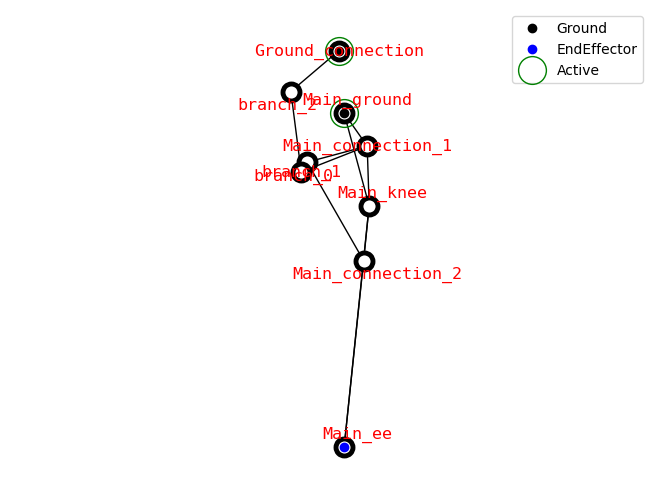

In [39]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
q = 0.2
weights = np.array([q, 1-q])
decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]
print(f"Best regarding ASF: F = {F[b]}")
graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)

In [40]:
import ipywidgets as widgets
import meshcat
from pinocchio.visualize import MeshcatVisualizer
from IPython.display import display, clear_output, HTML, IFrame, Image
from auto_robot_design.description.mesh_builder.urdf_creater import (
    URDFMeshCreator,
    MeshCreator,
)
from auto_robot_design.description.mesh_builder.mesh_builder import (
    MeshBuilder,
    jps_graph2pinocchio_meshes_robot,
)
import pinocchio as pin
import time
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager

tp = problem.graph_manager
mesh_builder = get_mesh_builder()
output = widgets.Output()

fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(tp.graph, mesh_builder)
visualizer = MeshcatVisualizer(
    fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model
)
with output:
    visualizer.viewer = meshcat.Visualizer()
visualizer.viewer["/Background"].set_property("visible", False)
visualizer.viewer["/Grid"].set_property("visible", False)
visualizer.viewer["/Axes"].set_property("visible", False)
visualizer.viewer["/Cameras/default/rotated/<object>"].set_property(
    "position", [0, 0.0, 0.8]
)
visualizer.clean()
visualizer.loadViewerModel()
visualizer.display(pin.neutral(fixed_robot.model))
with output:
    output.clear_output(wait=True)
    display(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

#output.append_display_data(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

def run_simulation(b):
    trajectory = problem.rewards_and_trajectories.trajectories[1]
    ik_manager = TrajectoryIKManager()
    # fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph, builder)
    fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(tp.graph, mesh_builder)
    ik_manager.register_model(
        fixed_robot.model, fixed_robot.constraint_models, fixed_robot.visual_model
    )
    ik_manager.set_solver("Closed_Loop_PI")
    poses, q_fixed, constraint_errors, reach_array = ik_manager.follow_trajectory(
        trajectory, viz=visualizer
    )
    time.sleep(0.5)
    visualizer.display(pin.neutral(fixed_robot.model))

first_run_button = widgets.Button(description='run simulation', layout=widgets.Layout(width='200px', height='40px')) 
first_run_button.style.button_color = 'lightblue'
first_run_button.on_click(run_simulation)
display(output, first_run_button)

Output()

Button(description='run simulation', layout=Layout(height='40px', width='200px'), style=ButtonStyle(button_col…

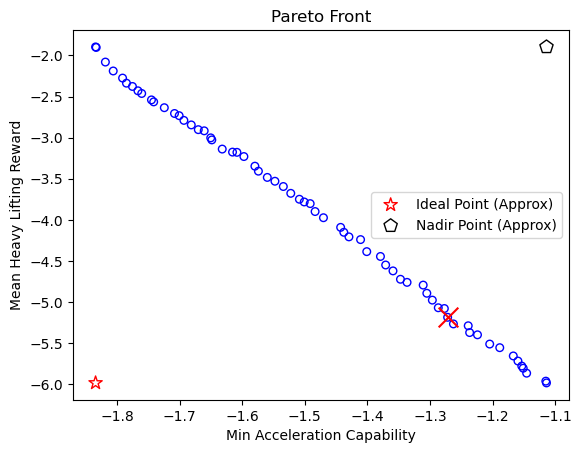

In [41]:
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none',
            edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none',
            edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.scatter(F[b, 0], F[b, 1], marker="x", color="red", s=200)
plt.title('Pareto Front')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.legend()
plt.show()



In [42]:
histF = np.array(optimizer.history["F"])
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 0.66734375


In [43]:
worstF1_id = np.argmax(validF1)
worstF2_id = np.argmax(validF2)
worst_reward2 = validF2[worstF2_id]
worst_reward1 = validF1[worstF1_id]
print('The maximum result in optimization task:', worst_reward1, worst_reward2)

The maximum result in optimization task: -0.7895251180231572 -0.573198157251717


In [44]:
bestF1_id = np.argmin(validF1)
bestF2_id = np.argmin(validF2)
bestF1_x = optimizer.history["X"][np.where(histF[:,0]==validF1[bestF1_id])[0][0]]
bestF1_reward = validF1[bestF1_id]
bestF2_x = optimizer.history["X"][np.where(histF[:,1]==validF2[bestF2_id])[0][0]]
bestF2_reward = validF2[bestF2_id]
print("The minimum result in optimization task: F1:", bestF1_reward, " F2: ", bestF2_reward, f" F: weights: {weights}", F[b])

The minimum result in optimization task: F1: -1.8344049576918282  F2:  -5.985449381843012  F: weights: [0.2 0.8] [-1.27188712 -5.18687341]


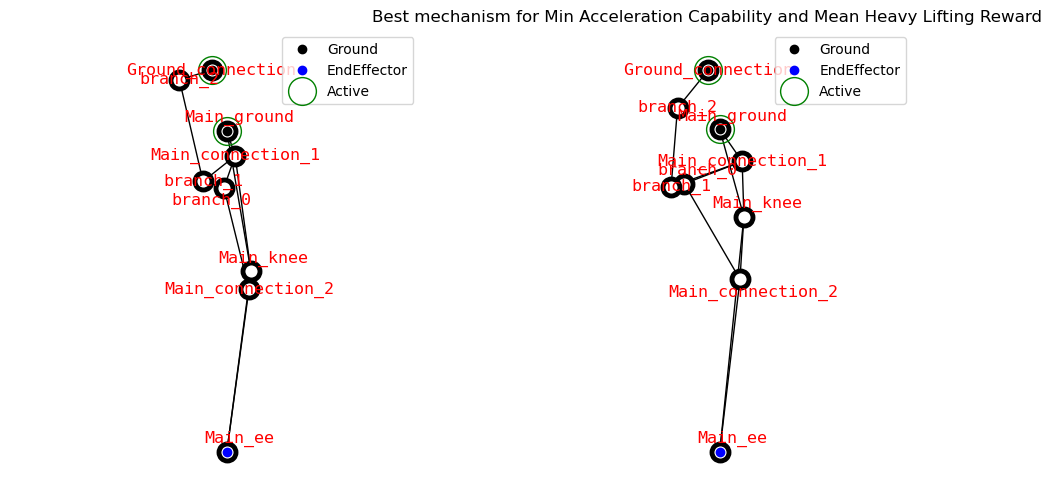

In [45]:
gm = problem.graph_manager
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
graph = gm.get_graph(bestF1_x)
draw_joint_point(graph)
plt.subplot(1, 3, 2)
graph = gm.get_graph(bestF2_x)
plt.title(f'Best mechanism for {labels[0]} and {labels[1]}', loc='center')
draw_joint_point(graph)


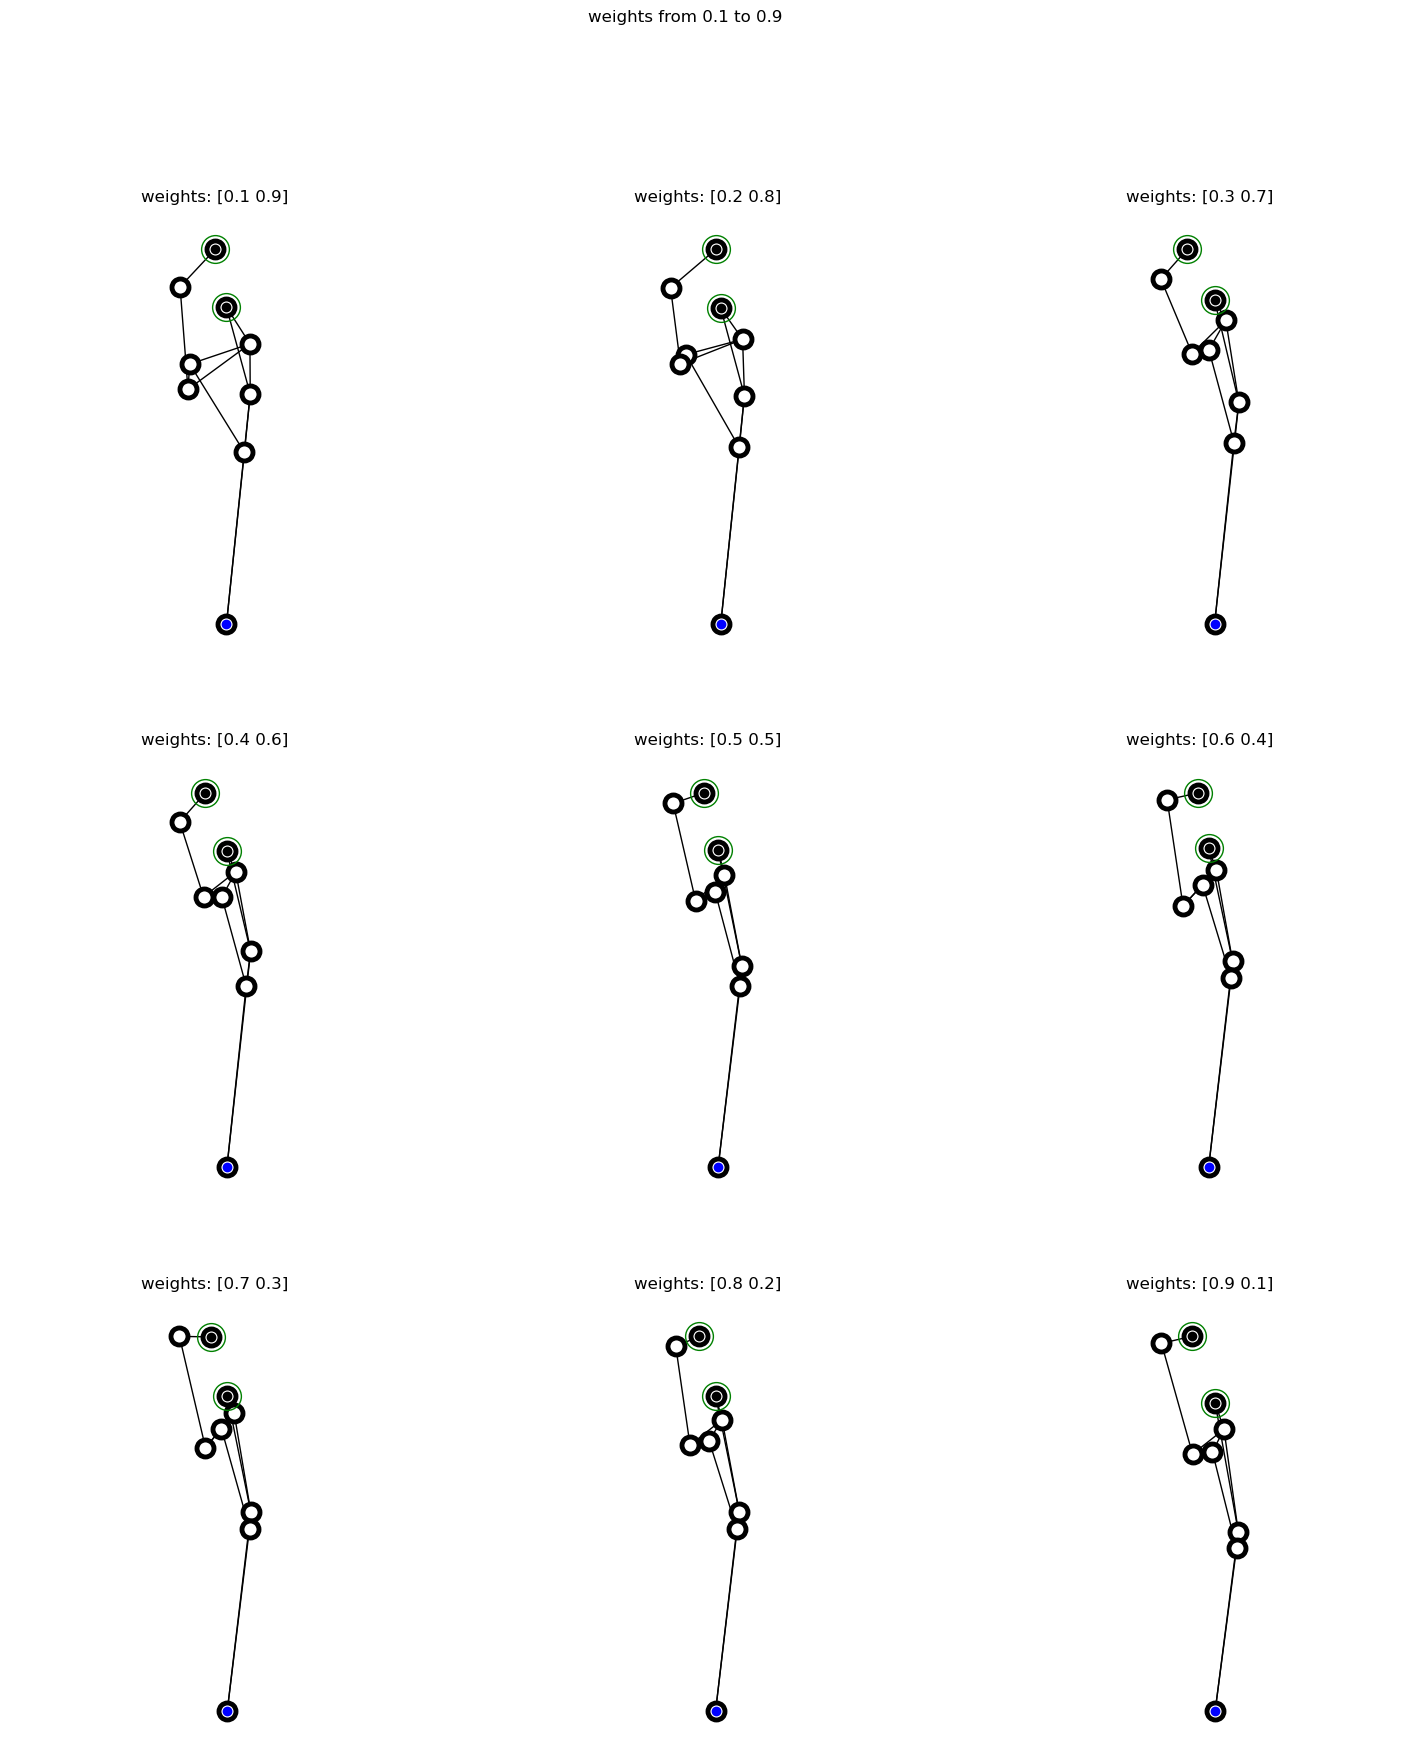

In [46]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
decomp = ASF()
weights_vector = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(18, 20))
for i, w in enumerate(weights_vector):
    weights = np.array([w, 1-w])
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[b]
    graph = problem.graph_manager.get_graph(best_x)
    plt.subplot(3, 3, i+1)
    plt.title(f'weights: {weights}')
    draw_joint_point(graph,draw_labels=False)
plt.suptitle('weights from 0.1 to 0.9')
plt.show()